In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)



In [20]:
spark = SparkSession.builder \
.master("local") \
.appName("weatherPrediction") \
.getOrCreate()

In [21]:
df = spark.read.csv("exampleData.csv", header=True, inferSchema=True)

### Exploring the Schema

In [18]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- indicator_rain: integer (nullable = true)
 |-- precipitation: string (nullable = true)
 |-- indicator_temp: integer (nullable = true)
 |-- air_temperature: string (nullable = true)
 |-- indicator_wetb: integer (nullable = true)
 |-- wetb: string (nullable = true)
 |-- dewpt: string (nullable = true)
 |-- vappr: string (nullable = true)
 |-- relative_humidity: string (nullable = true)
 |-- msl: string (nullable = true)
 |-- indicator_wdsp: integer (nullable = true)
 |-- wind_speed: string (nullable = true)
 |-- indicator_wddir: integer (nullable = true)
 |-- wind_from_direction: integer (nullable = true)



In [22]:
df.dtypes

[('_c0', 'int'),
 ('dateTime', 'string'),
 ('indicator_rain', 'int'),
 ('precipitation', 'string'),
 ('indicator_temp', 'int'),
 ('air_temperature', 'string'),
 ('indicator_wetb', 'int'),
 ('wetb', 'string'),
 ('dewpt', 'string'),
 ('vappr', 'string'),
 ('relative_humidity', 'string'),
 ('msl', 'string'),
 ('indicator_wdsp', 'int'),
 ('wind_speed', 'string'),
 ('indicator_wddir', 'int'),
 ('wind_from_direction', 'int')]

###  Indexing the data with StringIndexer
#### StringIndexer encodes a string column to a column with indices. In this data, we have a datetime parameter with actual string values. So to make the learner (model) understand the string values, we will use a string indexer.

In [25]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="dateTime", outputCol="indexedTime")
indexed = indexer.fit(df).transform(df)


In [26]:
indexed.show(vertical=True)

-RECORD 0--------------------------------
 _c0                 | 14                
 dateTime            | 01-jan-1990 00:00 
 indicator_rain      | 0                 
 precipitation       | 0.3               
 indicator_temp      | 0                 
 air_temperature     | 9.1               
 indicator_wetb      | 0                 
 wetb                | 9.0               
 dewpt               | 8.9               
 vappr               | 11.4              
 relative_humidity   | 99                
 msl                 | 1006.7            
 indicator_wdsp      | 2                 
 wind_speed          | 7                 
 indicator_wddir     | 2                 
 wind_from_direction | 190               
 indexedTime         | 2667.0            
-RECORD 1--------------------------------
 _c0                 | 15                
 dateTime            | 01-jan-1990 01:00 
 indicator_rain      | 0                 
 precipitation       | 0.2               
 indicator_temp      | 0          

### Chaning the Datatypes of the parameters to vectorize the data for training
#### independent variables: DateTime, relative_humidity, wind_speed, msl
#### target variable: air_temperature

In [28]:
parsed_data = indexed.selectExpr("cast(dateTime as string)dateTime", "cast(relative_humidity as float)relative_humidity","cast(wind_speed as float) wind_speed", \
"cast(indexedTime as double)indexedTime","cast(air_temperature as float) label","cast(msl as float) msl")

### Vectorize data and generate features

In [29]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols=['relative_humidity', 'wind_speed', 'indexedTime', 'msl'], handleInvalid="skip", outputCol='features')
vectorized_df = vectorAssembler.transform(parsed_data)
dataset = vectorized_df.select("features", "label")

### Splitting Data

In [30]:
(train, test) = dataset.randomSplit([0.7,0.3])

### Training a Gradient-Boosted Trees (GBTs) 

In [31]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", maxIter=30, maxDepth=11)

In [32]:
model = gbt.fit(train)

In [34]:
pred = model.transform(test)

### Visualizing the prediction

In [38]:
import seaborn
from scipy.stats import *

def visualize_pred(preds):
    pred_pd = preds.toPandas()

    seaborn.set(style="whitegrid", font_scale = 1.8)
    fig, ax = plt.subplots()
    seaborn.set(color_codes=True)
    seaborn.set(rc={'figure.figsize':(20, 10)})
    seaborn.regplot(x="label", y="prediction", fit_reg=False, ax=ax,data = pred_pd,scatter_kws={"color": "b"});
    seaborn.regplot(x="label", y="prediction",scatter=False, ax=ax, data = pred_pd, line_kws={"color": "red"});

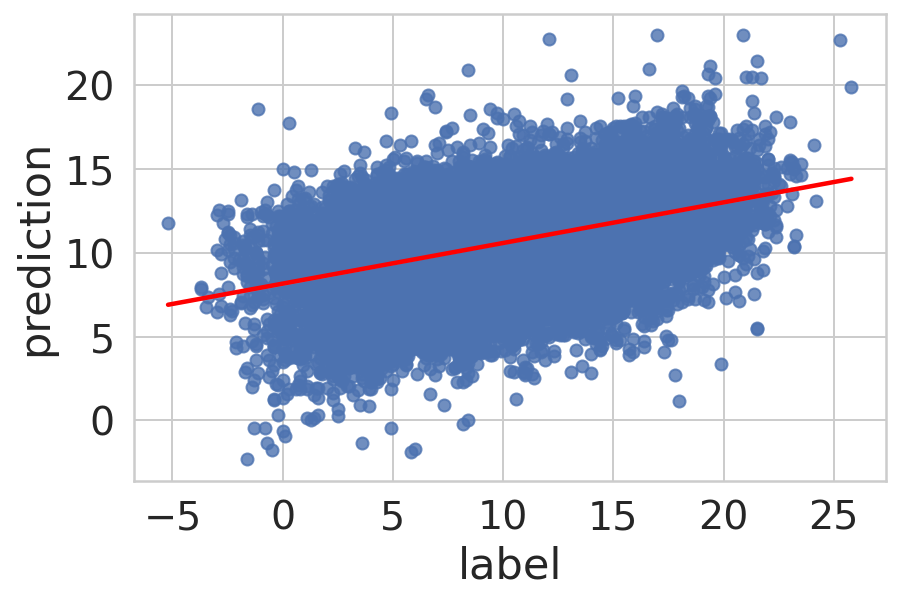

In [39]:
visualize_pred(pred)

### Spark ML Pipelines

In [40]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [41]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", handleInvalid="skip").fit(dataset)


#### Chain indexer and GBT in a Pipeline

In [42]:
pipeline = Pipeline(stages=[featureIndexer, gbt])

In [43]:
model_gbt = pipeline.fit(train)

In [44]:
predictions = model_gbt.transform(test)

####  Select (prediction, true label) and compute test error

In [46]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
rmse = evaluator.evaluate(predictions)
print("R Squared on test data = %g" % rmse)

R Squared on test data = 0.219975


In [48]:
evaluator = RegressionEvaluator(
labelCol="label", predictionCol="prediction", metricName="mae")
mae= evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)

MAE on test data = 2.82034


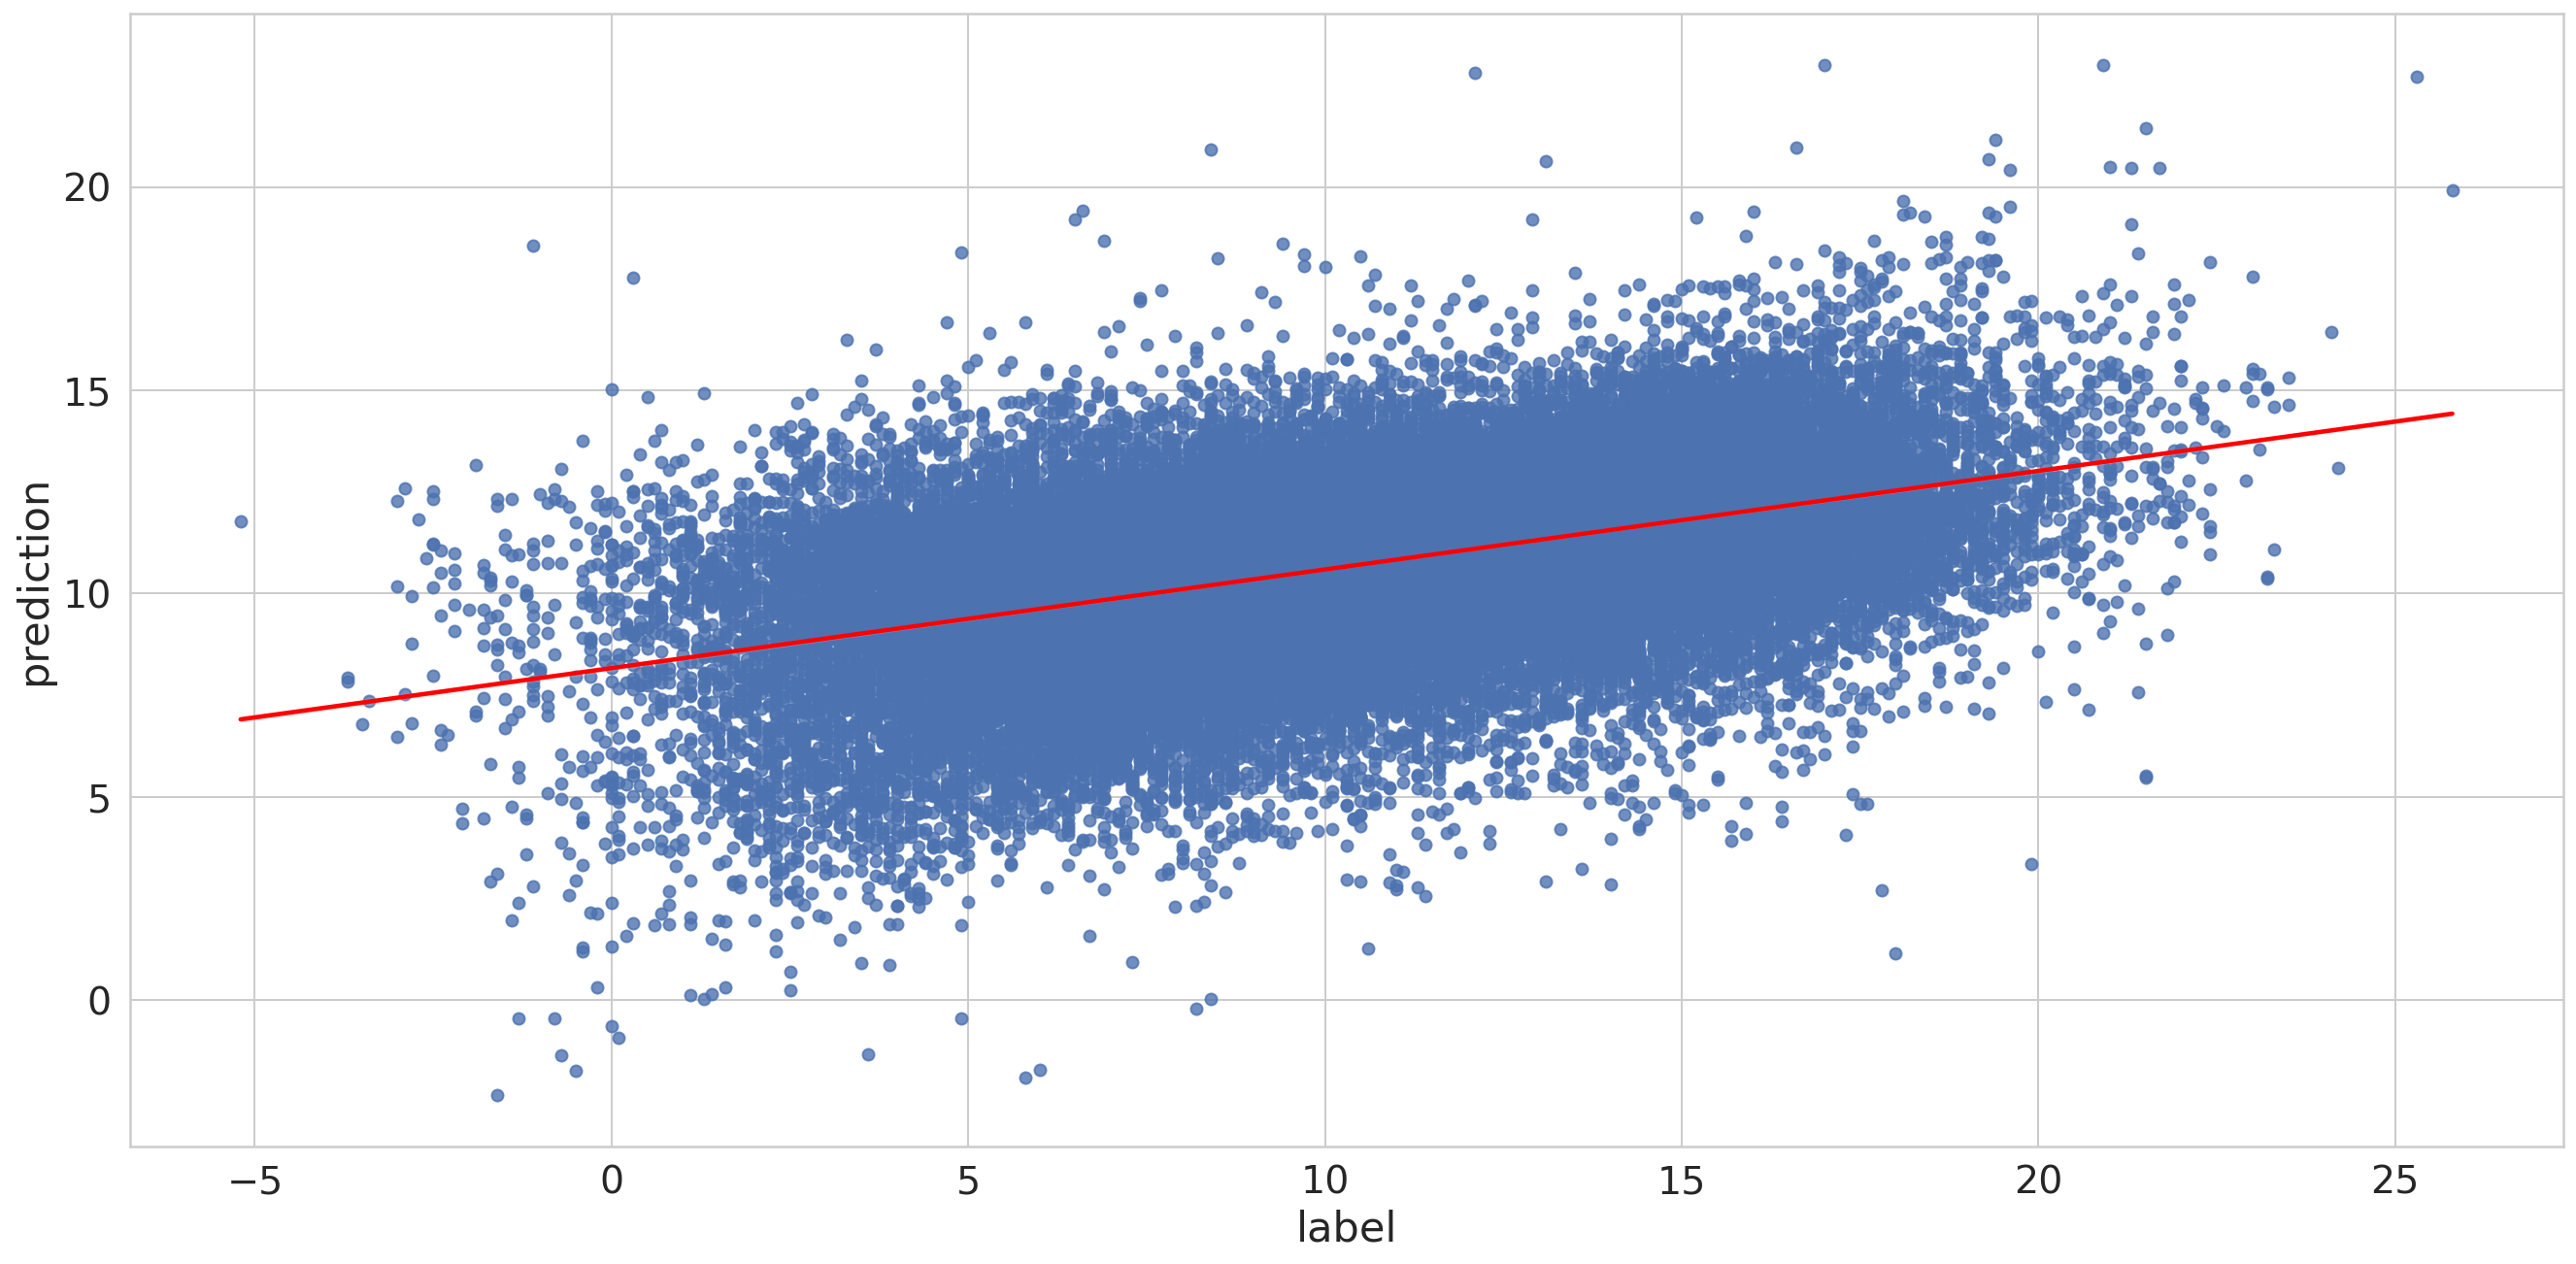

In [49]:
visualize_pred(predictions)